# Image Classifier
Using the dataset ("train.h5" and "test.h5") containing:
- a training set of 209 train images labeled as cat (y=1) or non-cat (y=0)
- a test set of 50 test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3)/(64,64,3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

We will build a simple image-recognition algorithm that can correctly classify images as cat or non-cat.We build separate functions that are required to build a neural net structure and merge them finally to classify the images depending on whether it is a cat picture or non cat picture.


In [37]:
#Import libraries
# h5py is to interact with a dataset that is stored on an H5 file.
# matplotlib is to plot graphs in Python.

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

%matplotlib inline

In [38]:
# Loading the data (cat/non-cat)
#Function to load data set
#Data is contained in train.h5 and test.h5 filesfrom the Datasets folder in github
def load_dataset():
    train_dataset = h5py.File('train.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


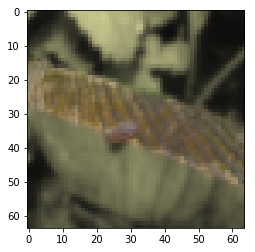

In [39]:
# Example of a picture in the data set
index = 12
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [40]:
#Checking the structure of data set
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig[1].shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


## Preprocessing

- We reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px∗num_px∗3,1) 
- Each column will represent a flattened image
- We also standardize our columns by dividing every row of the dataset by 255 (the maximum value of a pixel channel).


In [41]:
# Reshape the training and test examples
#Flattening the images

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [42]:
#Standardizing the dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## Building a Neural Network
The main steps for building a Neural Network are:
- Define the model structure (such as number of input features) 
- Initialize the model's parameters
- Loop:
      Calculate current loss (forward propagation)
      Calculate current gradient (backward propagation)
      Update parameters (gradient descent)

In [43]:
# Computing the sigmoid of z

def sigmoid(z):
    s = 1/(1+np.exp(-z))  
    return s

#We initialize the weight vectors with zeros
# This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
#dim :size of the w vector we want (or number of parameters in this case)
# w : initialized vector of shape (dim, 1)
#b : initialized scalar (corresponds to the bias)
 
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

## Forward and Backward Propogation
 After initializing the parameters, we now perform forward and backward propogation to learn the parameters
 
 Forward Propagation:
- We get X,input data of size (num_px \* num_px * 3, number of examples)
- Y is the true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
- We already initialized the parameters w and b where w is the weights (numpy array of size (num_px * num_px * 3, 1)) and b is the bias
- We compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
 
 where A is the activation array of each layer
 
 
- We then calculate the cost function: 
$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$


$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$
 
 The propagate function will return
- cost -- negative log-likelihood cost for logistic regression
- dw -- gradient of the loss with respect to w, thus same shape as w
- db -- gradient of the loss with respect to b, thus same shape as b 
 

In [44]:
def propagate(w, b, X, Y):

    m = X.shape[1]
    
    # implementing forward propogation(from X (input) to cost)
    A = sigmoid(np.dot(w.T,X)+b)                                   
    cost = (-1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))                                
    
    # implementing backward propogation(to find gradient)
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (np.sum(A-Y))/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {"dw": dw,
             "db": db}
    return grads, cost

## Learn the parameters/Optimization
We learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.
This function should optimize w and b by running a gradient descent algorithm with arguments
 - num_iterations -- number of iterations of the optimization loop
 - learning_rate -- learning rate of the gradient descent update rule
The function will return
- params: dictionary containing the weights w and bias b
- grads: dictionary containing the gradients of the weights and bias with respect to the cost function
- costs:list of all the costs computed during the optimization, this will be used to plot the learning curve.

In [45]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
   
    costs = []
    
    for i in range(num_iterations):
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieving derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w-(learning_rate*dw)
        b = b-(learning_rate*db)
      
        
        # Recording the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Printing the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

# Predict
The previous function will output the learned w and b. We will use w and b to predict the labels for a dataset X.The prediction involves two steps

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. 

In [46]:
#Predicting whether the label is 0 or 1 using learned parameters (w, b)
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Computing vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Converting probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
     
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## Merging all functions
We now build the model by calling all the functions implemented previously.The function will return
- d: dictionary containing information about the model.

In [47]:


def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    
    # initializing parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # performing Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieving parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predicting test/train set examples (
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Printing train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [48]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


- Training accuracy is close to 100%. The model  has high enough capacity to fit the training data. 
- Test error is 68%.We can observe that the model is  overfitting the training data. 

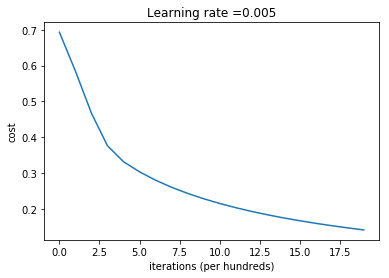

In [50]:
# Ploting learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

- We can see that the cost decreasing. It shows that the parameters are being learned. 

# Learning rate 

- Learning rate,$\alpha$  is a hyper parameter for the model.It determines how rapidly we update the parameters.
- If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

- Below we compare the learning curve of our model with several choices of learning rates. 

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



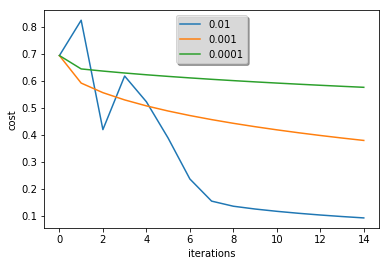

In [51]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

- As we can see different learning rates give different costs and thus different predictions results.
- We should choose the learning rate that better minimizes the cost function.


References: 
- This project is based upon the assignments in Neural Networks and Deep Learning course by Andrew Ng in Coursera
- The dataset is taken from the course material

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c